In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from transformers import BertTokenizer
import pickle

from textattack.models.wrappers import ModelWrapper
from textattack.datasets import HuggingFaceDataset
from textattack.attack_recipes import PWWSRen2019
from textattack import Attacker, AttackArgs

In [2]:
import torch
from torch.nn import CrossEntropyLoss
import textattack
from model_wrapper import ModelWrapper

from models import model_1 as mm

In [3]:
torch.cuda.empty_cache()

### PyTorchModelWrapper

In [4]:
class PyTorchModelWrapper(ModelWrapper):
    """Loads a PyTorch model (`nn.Module`) and tokenizer.

    Args:
        model (torch.nn.Module): PyTorch model
        tokenizer: tokenizer whose output can be packed as a tensor and passed to the model.
            No type requirement, but most have `tokenizer` method that accepts list of strings.
    """

    def __init__(self, model, tokenizer):
        if not isinstance(model, torch.nn.Module):
            raise TypeError(
                f"PyTorch model must be torch.nn.Module, got type {type(model)}"
            )

        self.model = model
        self.tokenizer = tokenizer

    def to(self, device):
        self.model.to(device)

    def __call__(self, text_input_list, batch_size=32):
        model_device = next(self.model.parameters()).device
        ############################################################ Change 1
        ids = self.tokenizer(text_input_list, return_tensors="pt", padding=True)
        ids = ids.to(model_device)

        with torch.no_grad():
            outputs = textattack.shared.utils.batch_model_predict(
                self.model, ids, batch_size=batch_size
            )

        return outputs

    def get_grad(self, text_input, loss_fn=CrossEntropyLoss()):
        """Get gradient of loss with respect to input tokens.

        Args:
            text_input (str): input string
            loss_fn (torch.nn.Module): loss function. Default is `torch.nn.CrossEntropyLoss`
        Returns:
            Dict of ids, tokens, and gradient as numpy array.
        """

        if not hasattr(self.model, "get_input_embeddings"):
            raise AttributeError(
                f"{type(self.model)} must have method `get_input_embeddings` that returns `torch.nn.Embedding` object that represents input embedding layer"
            )
        if not isinstance(loss_fn, torch.nn.Module):
            raise ValueError("Loss function must be of type `torch.nn.Module`.")

        self.model.train()

        embedding_layer = self.model.get_input_embeddings()
        original_state = embedding_layer.weight.requires_grad
        embedding_layer.weight.requires_grad = True

        emb_grads = []

        def grad_hook(module, grad_in, grad_out):
            emb_grads.append(grad_out[0])

        emb_hook = embedding_layer.register_backward_hook(grad_hook)

        self.model.zero_grad()
        model_device = next(self.model.parameters()).device
        
        ######################################################### Change 2
        ids = self.tokenizer(text_input_list, return_tensors="pt", padding=True)
        ids = ids.to(model_device)

        predictions = self.model(ids)

        output = predictions.argmax(dim=1)
        loss = loss_fn(predictions, output)
        loss.backward()

        # grad w.r.t to word embeddings

        # Fix for Issue #601

        # Check if gradient has shape [max_sequence,1,_] ( when model input in transpose of input sequence)

        if emb_grads[0].shape[1] == 1:
            grad = torch.transpose(emb_grads[0], 0, 1)[0].cpu().numpy()
        else:
            # gradient has shape [1,max_sequence,_]
            grad = emb_grads[0][0].cpu().numpy()

        embedding_layer.weight.requires_grad = original_state
        emb_hook.remove()
        self.model.eval()

        output = {"ids": ids[0].tolist(), "gradient": grad}

        return output

    def _tokenize(self, inputs):
        """Helper method that for `tokenize`
        Args:
            inputs (list[str]): list of input strings
        Returns:
            tokens (list[list[str]]): List of list of tokens as strings
        """
        return [self.tokenizer.convert_ids_to_tokens(self.tokenizer(x)) for x in inputs]

### Self Tx

In [5]:
d_model = 768
max_token = 512
nhead = 12
nlayer = 6
device = "cuda"

In [6]:
with open("bert_embedding.pkl", "rb") as file:
    embd = pickle.load(file)

In [7]:
model = mm.ad_transformer(d_model,nhead, nlayer, max_token, embd, device).to(device)

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [9]:
model.load_state_dict(torch.load("weight_trained_1.pth"))

<All keys matched successfully>

### Spam Dataset

In [10]:
#f = pd.read_csv("dataset/spam_train.csv")

In [11]:
#df = df.drop("len", axis=1)

In [12]:
### Removing Sequence more than 500 tokens
#tok_threshold = []
#for i in range(len(df) - 1, -1, -1):
#    tok_len = len(tokenizer(df.iloc[i,1], return_tensors="pt", padding=True)["input_ids"][0])
#    if tok_len > 500:
#        tok_threshold.append(i)
#        
#df.drop(859, inplace=True)

In [13]:
#df = df[df["text_type"] == "spam"]

In [14]:
#df_test.to_csv("attack_spam_only.csv", index = False)

In [15]:
df_test = pd.read_csv("dataset/attack_test.csv")

In [16]:
df_test = df_test.replace("spam",0)

### Testing Acurracy

In [17]:
## Actual Value (SPAM, HAM)  ## Y - Predicted Value (SPAM, HAM)
#conf_matrix = np.zeros((2,2))

In [18]:
"""
for i in range(len(df_test)):
    input_list = df_test.iloc[i,1]
    tok_input = tokenizer(input_list, return_tensors="pt", padding=True).to(device)
    out = model(tok_input)
    
    index_1 = torch.argmax(out[0]).tolist()
    
    if df_test.iloc[i,0] == 0:
        index_2 = 0
    else:
        index_2 = 1
        
    conf_matrix[index_1][index_2] += 1
"""

'\nfor i in range(len(df_test)):\n    input_list = df_test.iloc[i,1]\n    tok_input = tokenizer(input_list, return_tensors="pt", padding=True).to(device)\n    out = model(tok_input)\n    \n    index_1 = torch.argmax(out[0]).tolist()\n    \n    if df_test.iloc[i,0] == 0:\n        index_2 = 0\n    else:\n        index_2 = 1\n        \n    conf_matrix[index_1][index_2] += 1\n'

In [19]:
#conf_matrix

### Attack

In [20]:
df_test = df_test.rename(columns={'text_type': 'label'})

In [21]:
model_wrapper = PyTorchModelWrapper(model, tokenizer)

In [22]:
from textattack import Attack
from textattack.search_methods import GreedySearch
from textattack.constraints.pre_transformation import (
    RepeatModification,
    StopwordModification,
)
from textattack.goal_functions import UntargetedClassification, TargetedClassification
from textattack.transformations import WordSwapEmbedding
from textattack.constraints.pre_transformation import RepeatModification
from textattack.constraints.pre_transformation import StopwordModification

In [23]:
goal_function = TargetedClassification(model_wrapper, target_class = 1)

transformation = WordSwapEmbedding()

constraints = [RepeatModification(), StopwordModification()]

search_method = GreedySearch()

attack = Attack(goal_function, constraints, transformation, search_method)

textattack: Unknown if model of class <class 'models.model_1.ad_transformer'> compatible with goal function <class 'textattack.goal_functions.classification.targeted_classification.TargetedClassification'>.


In [24]:
custom_ds = []
for i in range(len(df_test)):
    custom_ds.append((df_test.iloc[i,1], int(df_test.iloc[i,0])))

In [25]:
dataset = textattack.datasets.Dataset(custom_ds)

In [39]:
### 21 success 9 failed

### Getting Low Rank of only Attention Weights

In [27]:
all_model_weight = model.state_dict()

In [34]:
all_model_weight['transformer_encoder.layers.0.linear1.weight'].shape

torch.Size([2048, 768])

In [150]:
def svd_sa(model, rank):
    all_model_weight = model.state_dict()
    
    for layer_num in range(nlayer):
        layer_name = 'transformer_encoder.layers.' + str(layer_num) + '.linear1.weight'

        in_proj_weight = all_model_weight[layer_name]

        U, s, V = np.linalg.svd(in_proj_weight.to("cpu").numpy())
        low_rank_mat = np.dot(U[:, :rank], np.dot(np.diag(s[:rank]), V[:rank, :]))
        in_proj_weight = low_rank_mat

        U, s, V = np.linalg.svd(k.to("cpu").numpy())
        low_rank_mat = np.dot(U[:, :rank], np.dot(np.diag(s[:rank]), V[:rank, :]))
        k = low_rank_mat

        U, s, V = np.linalg.svd(v.to("cpu").numpy())
        low_rank_mat = np.dot(U[:, :rank], np.dot(np.diag(s[:rank]), V[:rank, :]))
        v = low_rank_mat

        all_model_weight[layer_name] = torch.concat((torch.tensor(q),torch.tensor(k), torch.tensor(v))).to("cuda")
        
        return all_model_weight

### Experimenting on different rank

In [169]:
transformation = WordSwapEmbedding()
constraints = [RepeatModification(), StopwordModification()]
search_method = GreedySearch()

In [ ]:
for rank in range(50, 850, 50):
    model.load_state_dict(torch.load("weight_trained_1.pth"))
    
    all_model_weight = svd_sa(model, rank)
    model.load_state_dict(all_model_weight)
    
    model_wrapper = PyTorchModelWrapper(model, tokenizer)
    goal_function = TargetedClassification(model_wrapper, target_class = 1)
    attack = Attack(goal_function, constraints, transformation, search_method)
    
    attack_args = textattack.AttackArgs(
    num_examples=30,
    log_to_csv="rank/log_"+str(rank)+".csv",
    checkpoint_interval=5,
    checkpoint_dir="checkpoints",
    disable_stdout=True
    )
    
    attacker = Attacker(attack, dataset, attack_args)
    attacker.attack_dataset()

textattack: Unknown if model of class <class 'models.model_1.ad_transformer'> compatible with goal function <class 'textattack.goal_functions.classification.targeted_classification.TargetedClassification'>.
textattack: Logging to CSV at path rank/log_50.csv


Attack(
  (search_method): GreedySearch
  (goal_function):  TargetedClassification(
    (target_class):  1
  )
  (transformation):  WordSwapEmbedding(
    (max_candidates):  15
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 





  0%|                                                                                                                                    | 0/30 [00:00<?, ?it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1:   3%|██▎                                                                   | 1/30 [00:00<00:01, 20.69it/s]

[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1:   7%|████▋                                                                 | 2/30 [00:03<00:42,  1.52s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 1 / 2:   7%|████▋                                                                 | 2/30 [00:03<00:42,  1.53s/it]

[Succeeded / Failed / Skipped / Total] 2 / 0 / 1 / 3:  10%|███████                                                               | 3/30 [00:06<00:56,  2.11s/it]

[Succeeded / Failed / Skipped / Total] 2 / 0 / 1 / 3:  13%|█████████▎                                                            | 4/30 [00:09<01:04,  2.48s/it]

[Succeeded / Failed / Skip



[Succeeded / Failed / Skipped / Total] 4 / 0 / 1 / 5:  20%|██████████████                                                        | 6/30 [00:16<01:05,  2.72s/it]

[Succeeded / Failed / Skipped / Total] 5 / 0 / 1 / 6:  20%|██████████████                                                        | 6/30 [00:16<01:05,  2.73s/it]

[Succeeded / Failed / Skipped / Total] 6 / 0 / 1 / 7:  23%|████████████████▎                                                     | 7/30 [00:20<01:05,  2.86s/it]

[Succeeded / Failed / Skipped / Total] 6 / 0 / 1 / 7:  27%|██████████████████▋                                                   | 8/30 [00:20<00:56,  2.59s/it]

[Succeeded / Failed / Skipped / Total] 6 / 1 / 1 / 8:  27%|██████████████████▋                                                   | 8/30 [00:20<00:57,  2.59s/it]

[Succeeded / Failed / Skipped / Total] 7 / 1 / 1 / 9:  30%|█████████████████████                                                 | 9/30 [00:24<00:57,  2.73s/it]

[Succeeded / Failed / Skip



[Succeeded / Failed / Skipped / Total] 9 / 1 / 1 / 11:  37%|████████████████████████▉                                           | 11/30 [00:30<00:53,  2.82s/it]

[Succeeded / Failed / Skipped / Total] 9 / 1 / 1 / 11:  40%|███████████████████████████▏                                        | 12/30 [00:39<00:59,  3.30s/it]

[Succeeded / Failed / Skipped / Total] 9 / 2 / 1 / 12:  40%|███████████████████████████▏                                        | 12/30 [00:39<00:59,  3.30s/it]

[Succeeded / Failed / Skipped / Total] 9 / 2 / 1 / 12:  43%|█████████████████████████████▍                                      | 13/30 [00:47<01:02,  3.66s/it]

[Succeeded / Failed / Skipped / Total] 9 / 3 / 1 / 13:  43%|█████████████████████████████▍                                      | 13/30 [00:47<01:02,  3.66s/it]

[Succeeded / Failed / Skipped / Total] 9 / 3 / 1 / 13:  47%|███████████████████████████████▋                                    | 14/30 [00:51<00:58,  3.64s/it]

[Succeeded / Failed / Skip



[Succeeded / Failed / Skipped / Total] 10 / 4 / 1 / 15:  53%|███████████████████████████████████▋                               | 16/30 [01:12<01:03,  4.52s/it]

[Succeeded / Failed / Skipped / Total] 10 / 5 / 1 / 16:  53%|███████████████████████████████████▋                               | 16/30 [01:12<01:03,  4.52s/it]

[Succeeded / Failed / Skipped / Total] 10 / 5 / 1 / 16:  57%|█████████████████████████████████████▉                             | 17/30 [01:15<00:57,  4.45s/it]

[Succeeded / Failed / Skipped / Total] 11 / 5 / 1 / 17:  57%|█████████████████████████████████████▉                             | 17/30 [01:15<00:57,  4.46s/it]

[Succeeded / Failed / Skipped / Total] 11 / 5 / 1 / 17:  60%|████████████████████████████████████████▏                          | 18/30 [01:18<00:52,  4.38s/it]

[Succeeded / Failed / Skipped / Total] 12 / 5 / 1 / 18:  60%|████████████████████████████████████████▏                          | 18/30 [01:18<00:52,  4.38s/it]

[Succeeded / Failed / Skip



[Succeeded / Failed / Skipped / Total] 14 / 5 / 1 / 20:  70%|██████████████████████████████████████████████▉                    | 21/30 [01:39<00:42,  4.76s/it]

[Succeeded / Failed / Skipped / Total] 15 / 5 / 1 / 21:  70%|██████████████████████████████████████████████▉                    | 21/30 [01:39<00:42,  4.76s/it]

[Succeeded / Failed / Skipped / Total] 15 / 5 / 1 / 21:  73%|█████████████████████████████████████████████████▏                 | 22/30 [01:47<00:39,  4.90s/it]

[Succeeded / Failed / Skipped / Total] 16 / 5 / 1 / 22:  73%|█████████████████████████████████████████████████▏                 | 22/30 [01:47<00:39,  4.91s/it]

[Succeeded / Failed / Skipped / Total] 16 / 5 / 1 / 22:  77%|███████████████████████████████████████████████████▎               | 23/30 [01:53<00:34,  4.92s/it]

[Succeeded / Failed / Skipped / Total] 17 / 5 / 1 / 23:  77%|███████████████████████████████████████████████████▎               | 23/30 [01:53<00:34,  4.92s/it]

[Succeeded / Failed / Skip



[Succeeded / Failed / Skipped / Total] 18 / 6 / 1 / 25:  87%|██████████████████████████████████████████████████████████         | 26/30 [02:30<00:23,  5.78s/it]

[Succeeded / Failed / Skipped / Total] 19 / 6 / 1 / 26:  87%|██████████████████████████████████████████████████████████         | 26/30 [02:30<00:23,  5.78s/it]

[Succeeded / Failed / Skipped / Total] 19 / 6 / 1 / 26:  90%|████████████████████████████████████████████████████████████▎      | 27/30 [02:45<00:18,  6.14s/it]

[Succeeded / Failed / Skipped / Total] 20 / 6 / 1 / 27:  90%|████████████████████████████████████████████████████████████▎      | 27/30 [02:45<00:18,  6.14s/it]

[Succeeded / Failed / Skipped / Total] 20 / 6 / 1 / 27:  93%|██████████████████████████████████████████████████████████████▌    | 28/30 [02:56<00:12,  6.31s/it]

[Succeeded / Failed / Skipped / Total] 20 / 7 / 1 / 28:  93%|██████████████████████████████████████████████████████████████▌    | 28/30 [02:56<00:12,  6.31s/it]

[Succeeded / Failed / Skip





+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 22     |
| Number of failed attacks:     | 7      |
| Number of skipped attacks:    | 1      |
| Original accuracy:            | 96.67% |
| Accuracy under attack:        | 23.33% |
| Attack success rate:          | 75.86% |
| Average perturbed word %:     | 9.0%   |
| Average num. words per input: | 22.7   |
| Avg num queries:              | 399.28 |
+-------------------------------+--------+

textattack: Unknown if model of class <class 'models.model_1.ad_transformer'> compatible with goal function <class 'textattack.goal_functions.classification.targeted_classification.TargetedClassification'>.
textattack: Logging to CSV at path rank/log_100.csv


Attack(
  (search_method): GreedySearch
  (goal_function):  TargetedClassification(
    (target_class):  1
  )
  (transformation):  WordSwapEmbedding(
    (max_candidates):  15
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 





  0%|                                                                                                                                    | 0/30 [00:00<?, ?it/s]

  3%|████▏                                                                                                                       | 1/30 [00:02<01:18,  2.71s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:   3%|██▎                                                                   | 1/30 [00:02<01:19,  2.73s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:   7%|████▋                                                                 | 2/30 [00:05<01:22,  2.93s/it]

[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:   7%|████▋                                                                 | 2/30 [00:05<01:22,  2.94s/it]

[Succeeded / Failed / Skipped / Total] 2 / 0 / 0 / 2:  10%|███████                                                               | 3/30 [00:09<01:25,  3.18s/it]

[Succeeded / Failed / Skip



[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  20%|██████████████                                                        | 6/30 [00:20<01:20,  3.37s/it]

[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  20%|██████████████                                                        | 6/30 [00:20<01:20,  3.37s/it]

[Succeeded / Failed / Skipped / Total] 6 / 0 / 0 / 6:  23%|████████████████▎                                                     | 7/30 [00:23<01:18,  3.42s/it]

[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  23%|████████████████▎                                                     | 7/30 [00:23<01:18,  3.42s/it]

[Succeeded / Failed / Skipped / Total] 7 / 0 / 0 / 7:  27%|██████████████████▋                                                   | 8/30 [00:24<01:07,  3.08s/it]

[Succeeded / Failed / Skipped / Total] 7 / 1 / 0 / 8:  27%|██████████████████▋                                                   | 8/30 [00:24<01:08,  3.09s/it]

[Succeeded / Failed / Skip



[Succeeded / Failed / Skipped / Total] 9 / 1 / 0 / 10:  37%|████████████████████████▉                                           | 11/30 [00:40<01:09,  3.67s/it]

[Succeeded / Failed / Skipped / Total] 10 / 1 / 0 / 11:  37%|████████████████████████▌                                          | 11/30 [00:40<01:09,  3.67s/it]

[Succeeded / Failed / Skipped / Total] 10 / 1 / 0 / 11:  40%|██████████████████████████▊                                        | 12/30 [00:44<01:06,  3.68s/it]

[Succeeded / Failed / Skipped / Total] 11 / 1 / 0 / 12:  40%|██████████████████████████▊                                        | 12/30 [00:44<01:06,  3.69s/it]

[Succeeded / Failed / Skipped / Total] 11 / 1 / 0 / 12:  43%|█████████████████████████████                                      | 13/30 [00:52<01:09,  4.07s/it]

[Succeeded / Failed / Skipped / Total] 11 / 2 / 0 / 13:  43%|█████████████████████████████                                      | 13/30 [00:52<01:09,  4.07s/it]

[Succeeded / Failed / Skip



[Succeeded / Failed / Skipped / Total] 12 / 3 / 0 / 15:  53%|███████████████████████████████████▋                               | 16/30 [01:20<01:10,  5.03s/it]

[Succeeded / Failed / Skipped / Total] 12 / 4 / 0 / 16:  53%|███████████████████████████████████▋                               | 16/30 [01:20<01:10,  5.03s/it]

[Succeeded / Failed / Skipped / Total] 12 / 4 / 0 / 16:  57%|█████████████████████████████████████▉                             | 17/30 [01:24<01:04,  4.95s/it]

[Succeeded / Failed / Skipped / Total] 13 / 4 / 0 / 17:  57%|█████████████████████████████████████▉                             | 17/30 [01:24<01:04,  4.95s/it]

[Succeeded / Failed / Skipped / Total] 13 / 4 / 0 / 17:  60%|████████████████████████████████████████▏                          | 18/30 [01:27<00:58,  4.86s/it]

[Succeeded / Failed / Skipped / Total] 14 / 4 / 0 / 18:  60%|████████████████████████████████████████▏                          | 18/30 [01:27<00:58,  4.86s/it]

[Succeeded / Failed / Skip



[Succeeded / Failed / Skipped / Total] 16 / 4 / 0 / 20:  70%|██████████████████████████████████████████████▉                    | 21/30 [01:52<00:48,  5.36s/it]

[Succeeded / Failed / Skipped / Total] 17 / 4 / 0 / 21:  70%|██████████████████████████████████████████████▉                    | 21/30 [01:52<00:48,  5.36s/it]

[Succeeded / Failed / Skipped / Total] 17 / 4 / 0 / 21:  73%|█████████████████████████████████████████████████▏                 | 22/30 [01:57<00:42,  5.35s/it]

[Succeeded / Failed / Skipped / Total] 18 / 4 / 0 / 22:  73%|█████████████████████████████████████████████████▏                 | 22/30 [01:57<00:42,  5.35s/it]

[Succeeded / Failed / Skipped / Total] 18 / 4 / 0 / 22:  77%|███████████████████████████████████████████████████▎               | 23/30 [02:06<00:38,  5.52s/it]

[Succeeded / Failed / Skipped / Total] 19 / 4 / 0 / 23:  77%|███████████████████████████████████████████████████▎               | 23/30 [02:06<00:38,  5.52s/it]

[Succeeded / Failed / Skip



[Succeeded / Failed / Skipped / Total] 21 / 4 / 0 / 25:  87%|██████████████████████████████████████████████████████████         | 26/30 [02:48<00:25,  6.48s/it]

[Succeeded / Failed / Skipped / Total] 22 / 4 / 0 / 26:  87%|██████████████████████████████████████████████████████████         | 26/30 [02:48<00:25,  6.48s/it]

[Succeeded / Failed / Skipped / Total] 22 / 4 / 0 / 26:  90%|████████████████████████████████████████████████████████████▎      | 27/30 [03:01<00:20,  6.74s/it]

[Succeeded / Failed / Skipped / Total] 23 / 4 / 0 / 27:  90%|████████████████████████████████████████████████████████████▎      | 27/30 [03:01<00:20,  6.74s/it]

[Succeeded / Failed / Skipped / Total] 23 / 4 / 0 / 27:  93%|██████████████████████████████████████████████████████████████▌    | 28/30 [03:13<00:13,  6.90s/it]

[Succeeded / Failed / Skipped / Total] 23 / 5 / 0 / 28:  93%|██████████████████████████████████████████████████████████████▌    | 28/30 [03:13<00:13,  6.90s/it]

[Succeeded / Failed / Skip





+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 25     |
| Number of failed attacks:     | 5      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 16.67% |
| Attack success rate:          | 83.33% |
| Average perturbed word %:     | 11.03% |
| Average num. words per input: | 22.7   |
| Avg num queries:              | 405.0  |
+-------------------------------+--------+

textattack: Unknown if model of class <class 'models.model_1.ad_transformer'> compatible with goal function <class 'textattack.goal_functions.classification.targeted_classification.TargetedClassification'>.
textattack: Logging to CSV at path rank/log_150.csv


Attack(
  (search_method): GreedySearch
  (goal_function):  TargetedClassification(
    (target_class):  1
  )
  (transformation):  WordSwapEmbedding(
    (max_candidates):  15
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  17%|███████████▋                                                          | 5/30 [00:16<01:23,  3.35s/it]textattack: Saving checkpoint under "checkpoints/1713513728879.ta.chkpt" at 2024-04-19 08:02:08 after 5 attacks.


[Succeeded / Failed / Skipped / Total] 9 / 1 / 0 / 10:  33%|██████████████████████▋                                             | 10/30 [00:34<01:08,  3.40s/it]textattack: Saving checkpoint under "checkpoints/1713513746133.ta.chkpt" at 2024-04-19 08:02:26 after 10 attacks.


[Succeeded / Failed / Skipped / Total] 11 / 4 / 0 / 15:  50%|█████████████████████████████████▌                                 | 15/30 [01:10<01:10,  4.71s/it]textattack: Saving checkpoint under "checkpoints/1713513782841.ta.chkpt" at 2024-04-19 08:03:02 after 15 attacks.


[Succeeded / Failed / Skipped / Total] 16 / 4 / 0 / 20:  67%|████████████████████████████████████████████▋                      | 20/30 [01:47<00:53,  5.39s/it]textattack: Saving checkpoint under "checkpoints/1713513819872.ta.chkpt" at 2024-04-19 08:03:39 after 20 attacks.


[Succeeded / Failed / Skipped / Total] 20 / 5 / 0 / 25:  83%|███████████████████████████████████████████████████████▊           | 25/30 [02:41<00:32,  6.47s/it]textattack: Saving checkpoint under "checkpoints/1713513874003.ta.chkpt" at 2024-04-19 08:04:34 after 25 attacks.


[Succeeded / Failed / Skipped / Total] 24 / 6 / 0 / 30: 100%|███████████████████████████████████████████████████████████████████| 30/30 [03:24<00:00,  6.81s/it]textattack: Saving checkpoint under "checkpoints/1713513916437.ta.chkpt" at 2024-04-19 08:05:16 after 30 attacks.
[Succeeded / Failed / Skipped / Total] 24 / 6 / 0 / 30: 100%|███████████████████████████████████████████████████████████████████| 30/30 [03:24<00:00,  6.81s/it]





+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 24     |
| Number of failed attacks:     | 6      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 20.0%  |
| Attack success rate:          | 80.0%  |
| Average perturbed word %:     | 10.86% |
| Average num. words per input: | 22.7   |
| Avg num queries:              | 413.5  |
+-------------------------------+--------+

textattack: Unknown if model of class <class 'models.model_1.ad_transformer'> compatible with goal function <class 'textattack.goal_functions.classification.targeted_classification.TargetedClassification'>.
textattack: Logging to CSV at path rank/log_200.csv


Attack(
  (search_method): GreedySearch
  (goal_function):  TargetedClassification(
    (target_class):  1
  )
  (transformation):  WordSwapEmbedding(
    (max_candidates):  15
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  17%|███████████▋                                                          | 5/30 [00:17<01:25,  3.41s/it]textattack: Saving checkpoint under "checkpoints/1713513934890.ta.chkpt" at 2024-04-19 08:05:34 after 5 attacks.


[Succeeded / Failed / Skipped / Total] 9 / 1 / 0 / 10:  33%|██████████████████████▋                                             | 10/30 [00:33<01:07,  3.39s/it]textattack: Saving checkpoint under "checkpoints/1713513951762.ta.chkpt" at 2024-04-19 08:05:51 after 10 attacks.


[Succeeded / Failed / Skipped / Total] 12 / 3 / 0 / 15:  50%|█████████████████████████████████▌                                 | 15/30 [01:09<01:09,  4.65s/it]textattack: Saving checkpoint under "checkpoints/1713513987631.ta.chkpt" at 2024-04-19 08:06:27 after 15 attacks.


[Succeeded / Failed / Skipped / Total] 16 / 4 / 0 / 20:  67%|████████████████████████████████████████████▋                      | 20/30 [01:46<00:53,  5.33s/it]textattack: Saving checkpoint under "checkpoints/1713514024448.ta.chkpt" at 2024-04-19 08:07:04 after 20 attacks.


[Succeeded / Failed / Skipped / Total] 20 / 5 / 0 / 25:  83%|███████████████████████████████████████████████████████▊           | 25/30 [02:49<00:33,  6.76s/it]textattack: Saving checkpoint under "checkpoints/1713514086919.ta.chkpt" at 2024-04-19 08:08:06 after 25 attacks.


[Succeeded / Failed / Skipped / Total] 24 / 6 / 0 / 30: 100%|███████████████████████████████████████████████████████████████████| 30/30 [03:30<00:00,  7.03s/it]textattack: Saving checkpoint under "checkpoints/1713514128826.ta.chkpt" at 2024-04-19 08:08:48 after 30 attacks.
[Succeeded / Failed / Skipped / Total] 24 / 6 / 0 / 30: 100%|███████████████████████████████████████████████████████████████████| 30/30 [03:30<00:00,  7.03s/it]





+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 24     |
| Number of failed attacks:     | 6      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 20.0%  |
| Attack success rate:          | 80.0%  |
| Average perturbed word %:     | 12.48% |
| Average num. words per input: | 22.7   |
| Avg num queries:              | 426.5  |
+-------------------------------+--------+

textattack: Unknown if model of class <class 'models.model_1.ad_transformer'> compatible with goal function <class 'textattack.goal_functions.classification.targeted_classification.TargetedClassification'>.
textattack: Logging to CSV at path rank/log_250.csv


Attack(
  (search_method): GreedySearch
  (goal_function):  TargetedClassification(
    (target_class):  1
  )
  (transformation):  WordSwapEmbedding(
    (max_candidates):  15
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  17%|███████████▋                                                          | 5/30 [00:17<01:27,  3.49s/it]textattack: Saving checkpoint under "checkpoints/1713514147675.ta.chkpt" at 2024-04-19 08:09:07 after 5 attacks.


[Succeeded / Failed / Skipped / Total] 9 / 1 / 0 / 10:  33%|██████████████████████▋                                             | 10/30 [00:37<01:15,  3.78s/it]textattack: Saving checkpoint under "checkpoints/1713514168008.ta.chkpt" at 2024-04-19 08:09:28 after 10 attacks.


[Succeeded / Failed / Skipped / Total] 12 / 3 / 0 / 15:  50%|█████████████████████████████████▌                                 | 15/30 [01:09<01:09,  4.65s/it]textattack: Saving checkpoint under "checkpoints/1713514199962.ta.chkpt" at 2024-04-19 08:09:59 after 15 attacks.


[Succeeded / Failed / Skipped / Total] 16 / 4 / 0 / 20:  67%|████████████████████████████████████████████▋                      | 20/30 [01:51<00:55,  5.58s/it]textattack: Saving checkpoint under "checkpoints/1713514241728.ta.chkpt" at 2024-04-19 08:10:41 after 20 attacks.


[Succeeded / Failed / Skipped / Total] 19 / 6 / 0 / 25:  83%|███████████████████████████████████████████████████████▊           | 25/30 [02:48<00:33,  6.72s/it]textattack: Saving checkpoint under "checkpoints/1713514298330.ta.chkpt" at 2024-04-19 08:11:38 after 25 attacks.


[Succeeded / Failed / Skipped / Total] 23 / 7 / 0 / 30: 100%|███████████████████████████████████████████████████████████████████| 30/30 [03:33<00:00,  7.13s/it]textattack: Saving checkpoint under "checkpoints/1713514343983.ta.chkpt" at 2024-04-19 08:12:23 after 30 attacks.
[Succeeded / Failed / Skipped / Total] 23 / 7 / 0 / 30: 100%|███████████████████████████████████████████████████████████████████| 30/30 [03:33<00:00,  7.13s/it]





+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 23     |
| Number of failed attacks:     | 7      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 23.33% |
| Attack success rate:          | 76.67% |
| Average perturbed word %:     | 10.43% |
| Average num. words per input: | 22.7   |
| Avg num queries:              | 434.5  |
+-------------------------------+--------+

textattack: Unknown if model of class <class 'models.model_1.ad_transformer'> compatible with goal function <class 'textattack.goal_functions.classification.targeted_classification.TargetedClassification'>.
textattack: Logging to CSV at path rank/log_300.csv


Attack(
  (search_method): GreedySearch
  (goal_function):  TargetedClassification(
    (target_class):  1
  )
  (transformation):  WordSwapEmbedding(
    (max_candidates):  15
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  17%|███████████▋                                                          | 5/30 [00:19<01:39,  3.96s/it]textattack: Saving checkpoint under "checkpoints/1713514365234.ta.chkpt" at 2024-04-19 08:12:45 after 5 attacks.


[Succeeded / Failed / Skipped / Total] 9 / 1 / 0 / 10:  33%|██████████████████████▋                                             | 10/30 [00:36<01:13,  3.67s/it]textattack: Saving checkpoint under "checkpoints/1713514382123.ta.chkpt" at 2024-04-19 08:13:02 after 10 attacks.


[Succeeded / Failed / Skipped / Total] 12 / 3 / 0 / 15:  50%|█████████████████████████████████▌                                 | 15/30 [01:06<01:06,  4.41s/it]textattack: Saving checkpoint under "checkpoints/1713514411571.ta.chkpt" at 2024-04-19 08:13:31 after 15 attacks.


[Succeeded / Failed / Skipped / Total] 16 / 4 / 0 / 20:  67%|████████████████████████████████████████████▋                      | 20/30 [01:48<00:54,  5.41s/it]textattack: Saving checkpoint under "checkpoints/1713514453579.ta.chkpt" at 2024-04-19 08:14:13 after 20 attacks.


[Succeeded / Failed / Skipped / Total] 21 / 4 / 0 / 25:  83%|███████████████████████████████████████████████████████▊           | 25/30 [02:41<00:32,  6.45s/it]textattack: Saving checkpoint under "checkpoints/1713514506773.ta.chkpt" at 2024-04-19 08:15:06 after 25 attacks.


[Succeeded / Failed / Skipped / Total] 25 / 5 / 0 / 30: 100%|███████████████████████████████████████████████████████████████████| 30/30 [03:27<00:00,  6.93s/it]textattack: Saving checkpoint under "checkpoints/1713514553300.ta.chkpt" at 2024-04-19 08:15:53 after 30 attacks.
[Succeeded / Failed / Skipped / Total] 25 / 5 / 0 / 30: 100%|███████████████████████████████████████████████████████████████████| 30/30 [03:27<00:00,  6.93s/it]





+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 25     |
| Number of failed attacks:     | 5      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 16.67% |
| Attack success rate:          | 83.33% |
| Average perturbed word %:     | 12.26% |
| Average num. words per input: | 22.7   |
| Avg num queries:              | 428.0  |
+-------------------------------+--------+

textattack: Unknown if model of class <class 'models.model_1.ad_transformer'> compatible with goal function <class 'textattack.goal_functions.classification.targeted_classification.TargetedClassification'>.
textattack: Logging to CSV at path rank/log_350.csv


Attack(
  (search_method): GreedySearch
  (goal_function):  TargetedClassification(
    (target_class):  1
  )
  (transformation):  WordSwapEmbedding(
    (max_candidates):  15
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  17%|███████████▋                                                          | 5/30 [00:23<01:55,  4.62s/it]textattack: Saving checkpoint under "checkpoints/1713514577761.ta.chkpt" at 2024-04-19 08:16:17 after 5 attacks.


[Succeeded / Failed / Skipped / Total] 9 / 1 / 0 / 10:  33%|██████████████████████▋                                             | 10/30 [00:45<01:31,  4.56s/it]textattack: Saving checkpoint under "checkpoints/1713514600298.ta.chkpt" at 2024-04-19 08:16:40 after 10 attacks.


[Succeeded / Failed / Skipped / Total] 11 / 4 / 0 / 15:  50%|█████████████████████████████████▌                                 | 15/30 [01:23<01:23,  5.57s/it]textattack: Saving checkpoint under "checkpoints/1713514638170.ta.chkpt" at 2024-04-19 08:17:18 after 15 attacks.


[Succeeded / Failed / Skipped / Total] 16 / 4 / 0 / 20:  67%|████████████████████████████████████████████▋                      | 20/30 [02:07<01:03,  6.37s/it]textattack: Saving checkpoint under "checkpoints/1713514682028.ta.chkpt" at 2024-04-19 08:18:02 after 20 attacks.


[Succeeded / Failed / Skipped / Total] 19 / 6 / 0 / 25:  83%|███████████████████████████████████████████████████████▊           | 25/30 [03:05<00:37,  7.42s/it]textattack: Saving checkpoint under "checkpoints/1713514740277.ta.chkpt" at 2024-04-19 08:19:00 after 25 attacks.


[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  17%|███████████▋                                                          | 5/30 [00:23<01:59,  4.77s/it]textattack: Saving checkpoint under "checkpoints/1713514807915.ta.chkpt" at 2024-04-19 08:20:07 after 5 attacks.


[Succeeded / Failed / Skipped / Total] 9 / 1 / 0 / 10:  33%|██████████████████████▋                                             | 10/30 [00:45<01:31,  4.55s/it]textattack: Saving checkpoint under "checkpoints/1713514829593.ta.chkpt" at 2024-04-19 08:20:29 after 10 attacks.


[Succeeded / Failed / Skipped / Total] 9 / 1 / 0 / 10:  33%|██████████████████████▋                                             | 10/30 [00:45<01:31,  4.57s/it]textattack: Saving checkpoint under "checkpoints/1713515055119.ta.chkpt" at 2024-04-19 08:24:15 after 10 attacks.


[Succeeded / Failed / Skipped / Total] 11 / 4 / 0 / 15:  50%|█████████████████████████████████▌                                 | 15/30 [01:22<01:22,  5.50s/it]textattack: Saving checkpoint under "checkpoints/1713515091919.ta.chkpt" at 2024-04-19 08:24:51 after 15 attacks.


[Succeeded / Failed / Skipped / Total] 15 / 5 / 0 / 20:  67%|████████████████████████████████████████████▋                      | 20/30 [02:03<01:01,  6.19s/it]textattack: Saving checkpoint under "checkpoints/1713515133085.ta.chkpt" at 2024-04-19 08:25:33 after 20 attacks.


[Succeeded / Failed / Skipped / Total] 18 / 7 / 0 / 25:  83%|███████████████████████████████████████████████████████▊           | 25/30 [03:00<00:36,  7.21s/it]textattack: Saving checkpoint under "checkpoints/1713515189649.ta.chkpt" at 2024-04-19 08:26:29 after 25 attacks.


[Succeeded / Failed / Skipped / Total] 21 / 9 / 0 / 30: 100%|███████████████████████████████████████████████████████████████████| 30/30 [03:53<00:00,  7.80s/it]textattack: Saving checkpoint under "checkpoints/1713515243273.ta.chkpt" at 2024-04-19 08:27:23 after 30 attacks.
[Succeeded / Failed / Skipped / Total] 21 / 9 / 0 / 30: 100%|███████████████████████████████████████████████████████████████████| 30/30 [03:53<00:00,  7.80s/it]





+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 21     |
| Number of failed attacks:     | 9      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 30.0%  |
| Attack success rate:          | 70.0%  |
| Average perturbed word %:     | 10.83% |
| Average num. words per input: | 22.7   |
| Avg num queries:              | 476.0  |
+-------------------------------+--------+

textattack: Unknown if model of class <class 'models.model_1.ad_transformer'> compatible with goal function <class 'textattack.goal_functions.classification.targeted_classification.TargetedClassification'>.
textattack: Logging to CSV at path rank/log_500.csv


Attack(
  (search_method): GreedySearch
  (goal_function):  TargetedClassification(
    (target_class):  1
  )
  (transformation):  WordSwapEmbedding(
    (max_candidates):  15
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  17%|███████████▋                                                          | 5/30 [00:23<01:56,  4.68s/it]textattack: Saving checkpoint under "checkpoints/1713515268088.ta.chkpt" at 2024-04-19 08:27:48 after 5 attacks.


[Succeeded / Failed / Skipped / Total] 9 / 1 / 0 / 10:  33%|██████████████████████▋                                             | 10/30 [00:45<01:30,  4.54s/it]textattack: Saving checkpoint under "checkpoints/1713515290119.ta.chkpt" at 2024-04-19 08:28:10 after 10 attacks.


[Succeeded / Failed / Skipped / Total] 11 / 4 / 0 / 15:  50%|█████████████████████████████████▌                                 | 15/30 [01:21<01:21,  5.46s/it]textattack: Saving checkpoint under "checkpoints/1713515326572.ta.chkpt" at 2024-04-19 08:28:46 after 15 attacks.


[Succeeded / Failed / Skipped / Total] 15 / 5 / 0 / 20:  67%|████████████████████████████████████████████▋                      | 20/30 [02:02<01:01,  6.14s/it]textattack: Saving checkpoint under "checkpoints/1713515367488.ta.chkpt" at 2024-04-19 08:29:27 after 20 attacks.


[Succeeded / Failed / Skipped / Total] 19 / 6 / 0 / 25:  83%|███████████████████████████████████████████████████████▊           | 25/30 [02:51<00:34,  6.87s/it]textattack: Saving checkpoint under "checkpoints/1713515416394.ta.chkpt" at 2024-04-19 08:30:16 after 25 attacks.


[Succeeded / Failed / Skipped / Total] 23 / 7 / 0 / 30: 100%|███████████████████████████████████████████████████████████████████| 30/30 [03:43<00:00,  7.44s/it]textattack: Saving checkpoint under "checkpoints/1713515467966.ta.chkpt" at 2024-04-19 08:31:07 after 30 attacks.
[Succeeded / Failed / Skipped / Total] 23 / 7 / 0 / 30: 100%|███████████████████████████████████████████████████████████████████| 30/30 [03:43<00:00,  7.44s/it]





+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 23     |
| Number of failed attacks:     | 7      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 23.33% |
| Attack success rate:          | 76.67% |
| Average perturbed word %:     | 12.54% |
| Average num. words per input: | 22.7   |
| Avg num queries:              | 458.5  |
+-------------------------------+--------+

textattack: Unknown if model of class <class 'models.model_1.ad_transformer'> compatible with goal function <class 'textattack.goal_functions.classification.targeted_classification.TargetedClassification'>.
textattack: Logging to CSV at path rank/log_550.csv


Attack(
  (search_method): GreedySearch
  (goal_function):  TargetedClassification(
    (target_class):  1
  )
  (transformation):  WordSwapEmbedding(
    (max_candidates):  15
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  17%|███████████▋                                                          | 5/30 [00:23<01:55,  4.61s/it]textattack: Saving checkpoint under "checkpoints/1713515492420.ta.chkpt" at 2024-04-19 08:31:32 after 5 attacks.


[Succeeded / Failed / Skipped / Total] 9 / 1 / 0 / 10:  33%|██████████████████████▋                                             | 10/30 [00:43<01:26,  4.34s/it]textattack: Saving checkpoint under "checkpoints/1713515512781.ta.chkpt" at 2024-04-19 08:31:52 after 10 attacks.


[Succeeded / Failed / Skipped / Total] 12 / 3 / 0 / 15:  50%|█████████████████████████████████▌                                 | 15/30 [01:21<01:21,  5.43s/it]textattack: Saving checkpoint under "checkpoints/1713515550858.ta.chkpt" at 2024-04-19 08:32:30 after 15 attacks.


[Succeeded / Failed / Skipped / Total] 17 / 3 / 0 / 20:  67%|████████████████████████████████████████████▋                      | 20/30 [02:01<01:00,  6.10s/it]textattack: Saving checkpoint under "checkpoints/1713515591356.ta.chkpt" at 2024-04-19 08:33:11 after 20 attacks.


[Succeeded / Failed / Skipped / Total] 22 / 3 / 0 / 25:  83%|███████████████████████████████████████████████████████▊           | 25/30 [02:58<00:35,  7.15s/it]textattack: Saving checkpoint under "checkpoints/1713515648021.ta.chkpt" at 2024-04-19 08:34:08 after 25 attacks.


[Succeeded / Failed / Skipped / Total] 25 / 5 / 0 / 30: 100%|███████████████████████████████████████████████████████████████████| 30/30 [03:48<00:00,  7.61s/it]textattack: Saving checkpoint under "checkpoints/1713515697626.ta.chkpt" at 2024-04-19 08:34:57 after 30 attacks.
[Succeeded / Failed / Skipped / Total] 25 / 5 / 0 / 30: 100%|███████████████████████████████████████████████████████████████████| 30/30 [03:48<00:00,  7.61s/it]





+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 25     |
| Number of failed attacks:     | 5      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 16.67% |
| Attack success rate:          | 83.33% |
| Average perturbed word %:     | 13.37% |
| Average num. words per input: | 22.7   |
| Avg num queries:              | 465.5  |
+-------------------------------+--------+

textattack: Unknown if model of class <class 'models.model_1.ad_transformer'> compatible with goal function <class 'textattack.goal_functions.classification.targeted_classification.TargetedClassification'>.
textattack: Logging to CSV at path rank/log_600.csv


Attack(
  (search_method): GreedySearch
  (goal_function):  TargetedClassification(
    (target_class):  1
  )
  (transformation):  WordSwapEmbedding(
    (max_candidates):  15
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  17%|███████████▋                                                          | 5/30 [00:23<01:57,  4.70s/it]textattack: Saving checkpoint under "checkpoints/1713515722457.ta.chkpt" at 2024-04-19 08:35:22 after 5 attacks.


[Succeeded / Failed / Skipped / Total] 9 / 1 / 0 / 10:  33%|██████████████████████▋                                             | 10/30 [00:43<01:27,  4.37s/it]textattack: Saving checkpoint under "checkpoints/1713515742663.ta.chkpt" at 2024-04-19 08:35:42 after 10 attacks.


[Succeeded / Failed / Skipped / Total] 12 / 3 / 0 / 15:  50%|█████████████████████████████████▌                                 | 15/30 [01:21<01:21,  5.45s/it]textattack: Saving checkpoint under "checkpoints/1713515780799.ta.chkpt" at 2024-04-19 08:36:20 after 15 attacks.


[Succeeded / Failed / Skipped / Total] 16 / 4 / 0 / 20:  67%|████████████████████████████████████████████▋                      | 20/30 [02:21<01:10,  7.09s/it]textattack: Saving checkpoint under "checkpoints/1713515840683.ta.chkpt" at 2024-04-19 08:37:20 after 20 attacks.


[Succeeded / Failed / Skipped / Total] 20 / 5 / 0 / 25:  83%|███████████████████████████████████████████████████████▊           | 25/30 [03:26<00:41,  8.28s/it]textattack: Saving checkpoint under "checkpoints/1713515905905.ta.chkpt" at 2024-04-19 08:38:25 after 25 attacks.


[Succeeded / Failed / Skipped / Total] 23 / 7 / 0 / 30: 100%|███████████████████████████████████████████████████████████████████| 30/30 [04:23<00:00,  8.80s/it]textattack: Saving checkpoint under "checkpoints/1713515962977.ta.chkpt" at 2024-04-19 08:39:22 after 30 attacks.
[Succeeded / Failed / Skipped / Total] 23 / 7 / 0 / 30: 100%|███████████████████████████████████████████████████████████████████| 30/30 [04:24<00:00,  8.80s/it]





+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 23     |
| Number of failed attacks:     | 7      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 23.33% |
| Attack success rate:          | 76.67% |
| Average perturbed word %:     | 15.83% |
| Average num. words per input: | 22.7   |
| Avg num queries:              | 539.5  |
+-------------------------------+--------+

textattack: Unknown if model of class <class 'models.model_1.ad_transformer'> compatible with goal function <class 'textattack.goal_functions.classification.targeted_classification.TargetedClassification'>.
textattack: Logging to CSV at path rank/log_650.csv


Attack(
  (search_method): GreedySearch
  (goal_function):  TargetedClassification(
    (target_class):  1
  )
  (transformation):  WordSwapEmbedding(
    (max_candidates):  15
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  17%|███████████▋                                                          | 5/30 [00:23<01:56,  4.64s/it]textattack: Saving checkpoint under "checkpoints/1713515987594.ta.chkpt" at 2024-04-19 08:39:47 after 5 attacks.


[Succeeded / Failed / Skipped / Total] 9 / 1 / 0 / 10:  33%|██████████████████████▋                                             | 10/30 [00:43<01:27,  4.38s/it]textattack: Saving checkpoint under "checkpoints/1713516008224.ta.chkpt" at 2024-04-19 08:40:08 after 10 attacks.


[Succeeded / Failed / Skipped / Total] 12 / 3 / 0 / 15:  50%|█████████████████████████████████▌                                 | 15/30 [01:23<01:23,  5.55s/it]textattack: Saving checkpoint under "checkpoints/1713516047558.ta.chkpt" at 2024-04-19 08:40:47 after 15 attacks.


[Succeeded / Failed / Skipped / Total] 16 / 4 / 0 / 20:  67%|████████████████████████████████████████████▋                      | 20/30 [02:09<01:04,  6.49s/it]textattack: Saving checkpoint under "checkpoints/1713516094101.ta.chkpt" at 2024-04-19 08:41:34 after 20 attacks.


[Succeeded / Failed / Skipped / Total] 19 / 6 / 0 / 25:  83%|███████████████████████████████████████████████████████▊           | 25/30 [03:13<00:38,  7.73s/it]textattack: Saving checkpoint under "checkpoints/1713516157525.ta.chkpt" at 2024-04-19 08:42:37 after 25 attacks.


[Succeeded / Failed / Skipped / Total] 22 / 8 / 0 / 30: 100%|███████████████████████████████████████████████████████████████████| 30/30 [04:08<00:00,  8.27s/it]textattack: Saving checkpoint under "checkpoints/1713516212524.ta.chkpt" at 2024-04-19 08:43:32 after 30 attacks.
[Succeeded / Failed / Skipped / Total] 22 / 8 / 0 / 30: 100%|███████████████████████████████████████████████████████████████████| 30/30 [04:08<00:00,  8.27s/it]





+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 22     |
| Number of failed attacks:     | 8      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 26.67% |
| Attack success rate:          | 73.33% |
| Average perturbed word %:     | 13.26% |
| Average num. words per input: | 22.7   |
| Avg num queries:              | 513.0  |
+-------------------------------+--------+

textattack: Unknown if model of class <class 'models.model_1.ad_transformer'> compatible with goal function <class 'textattack.goal_functions.classification.targeted_classification.TargetedClassification'>.
textattack: Logging to CSV at path rank/log_700.csv


Attack(
  (search_method): GreedySearch
  (goal_function):  TargetedClassification(
    (target_class):  1
  )
  (transformation):  WordSwapEmbedding(
    (max_candidates):  15
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  17%|███████████▋                                                          | 5/30 [00:22<01:54,  4.56s/it]textattack: Saving checkpoint under "checkpoints/1713516236743.ta.chkpt" at 2024-04-19 08:43:56 after 5 attacks.


[Succeeded / Failed / Skipped / Total] 9 / 1 / 0 / 10:  33%|██████████████████████▋                                             | 10/30 [00:46<01:33,  4.69s/it]textattack: Saving checkpoint under "checkpoints/1713516260820.ta.chkpt" at 2024-04-19 08:44:20 after 10 attacks.


[Succeeded / Failed / Skipped / Total] 11 / 4 / 0 / 15:  50%|█████████████████████████████████▌                                 | 15/30 [01:27<01:27,  5.81s/it]textattack: Saving checkpoint under "checkpoints/1713516301125.ta.chkpt" at 2024-04-19 08:45:01 after 15 attacks.


[Succeeded / Failed / Skipped / Total] 15 / 5 / 0 / 20:  67%|████████████████████████████████████████████▋                      | 20/30 [02:26<01:13,  7.34s/it]textattack: Saving checkpoint under "checkpoints/1713516360770.ta.chkpt" at 2024-04-19 08:46:00 after 20 attacks.


[Succeeded / Failed / Skipped / Total] 19 / 6 / 0 / 25:  83%|███████████████████████████████████████████████████████▊           | 25/30 [03:29<00:41,  8.37s/it]textattack: Saving checkpoint under "checkpoints/1713516423293.ta.chkpt" at 2024-04-19 08:47:03 after 25 attacks.


[Succeeded / Failed / Skipped / Total] 23 / 7 / 0 / 30: 100%|███████████████████████████████████████████████████████████████████| 30/30 [04:26<00:00,  8.90s/it]textattack: Saving checkpoint under "checkpoints/1713516480923.ta.chkpt" at 2024-04-19 08:48:00 after 30 attacks.
[Succeeded / Failed / Skipped / Total] 23 / 7 / 0 / 30: 100%|███████████████████████████████████████████████████████████████████| 30/30 [04:26<00:00,  8.90s/it]





+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 23     |
| Number of failed attacks:     | 7      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 23.33% |
| Attack success rate:          | 76.67% |
| Average perturbed word %:     | 16.18% |
| Average num. words per input: | 22.7   |
| Avg num queries:              | 547.0  |
+-------------------------------+--------+

textattack: Unknown if model of class <class 'models.model_1.ad_transformer'> compatible with goal function <class 'textattack.goal_functions.classification.targeted_classification.TargetedClassification'>.
textattack: Logging to CSV at path rank/log_750.csv


Attack(
  (search_method): GreedySearch
  (goal_function):  TargetedClassification(
    (target_class):  1
  )
  (transformation):  WordSwapEmbedding(
    (max_candidates):  15
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  17%|███████████▋                                                          | 5/30 [00:22<01:54,  4.59s/it]textattack: Saving checkpoint under "checkpoints/1713516506127.ta.chkpt" at 2024-04-19 08:48:26 after 5 attacks.


[Succeeded / Failed / Skipped / Total] 9 / 1 / 0 / 10:  33%|██████████████████████▋                                             | 10/30 [00:46<01:33,  4.68s/it]textattack: Saving checkpoint under "checkpoints/1713516529981.ta.chkpt" at 2024-04-19 08:48:49 after 10 attacks.


[Succeeded / Failed / Skipped / Total] 11 / 4 / 0 / 15:  50%|█████████████████████████████████▌                                 | 15/30 [01:27<01:27,  5.86s/it]textattack: Saving checkpoint under "checkpoints/1713516571083.ta.chkpt" at 2024-04-19 08:49:31 after 15 attacks.


[Succeeded / Failed / Skipped / Total] 15 / 5 / 0 / 20:  67%|████████████████████████████████████████████▋                      | 20/30 [02:26<01:13,  7.34s/it]textattack: Saving checkpoint under "checkpoints/1713516629905.ta.chkpt" at 2024-04-19 08:50:29 after 20 attacks.


[Succeeded / Failed / Skipped / Total] 18 / 7 / 0 / 25:  83%|███████████████████████████████████████████████████████▊           | 25/30 [03:35<00:43,  8.64s/it]textattack: Saving checkpoint under "checkpoints/1713516699132.ta.chkpt" at 2024-04-19 08:51:39 after 25 attacks.


[Succeeded / Failed / Skipped / Total] 21 / 9 / 0 / 30: 100%|███████████████████████████████████████████████████████████████████| 30/30 [04:35<00:00,  9.20s/it]textattack: Saving checkpoint under "checkpoints/1713516759084.ta.chkpt" at 2024-04-19 08:52:39 after 30 attacks.
[Succeeded / Failed / Skipped / Total] 21 / 9 / 0 / 30: 100%|███████████████████████████████████████████████████████████████████| 30/30 [04:35<00:00,  9.20s/it]





+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 21     |
| Number of failed attacks:     | 9      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 30.0%  |
| Attack success rate:          | 70.0%  |
| Average perturbed word %:     | 15.83% |
| Average num. words per input: | 22.7   |
| Avg num queries:              | 570.5  |
+-------------------------------+--------+

textattack: Unknown if model of class <class 'models.model_1.ad_transformer'> compatible with goal function <class 'textattack.goal_functions.classification.targeted_classification.TargetedClassification'>.
textattack: Logging to CSV at path rank/log_800.csv


Attack(
  (search_method): GreedySearch
  (goal_function):  TargetedClassification(
    (target_class):  1
  )
  (transformation):  WordSwapEmbedding(
    (max_candidates):  15
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 5 / 0 / 0 / 5:  17%|███████████▋                                                          | 5/30 [00:23<01:55,  4.63s/it]textattack: Saving checkpoint under "checkpoints/1713516783666.ta.chkpt" at 2024-04-19 08:53:03 after 5 attacks.


[Succeeded / Failed / Skipped / Total] 9 / 1 / 0 / 10:  33%|██████████████████████▋                                             | 10/30 [00:47<01:34,  4.73s/it]textattack: Saving checkpoint under "checkpoints/1713516807826.ta.chkpt" at 2024-04-19 08:53:27 after 10 attacks.


[Succeeded / Failed / Skipped / Total] 11 / 4 / 0 / 15:  50%|█████████████████████████████████▌                                 | 15/30 [01:28<01:28,  5.91s/it]textattack: Saving checkpoint under "checkpoints/1713516849227.ta.chkpt" at 2024-04-19 08:54:09 after 15 attacks.


[Succeeded / Failed / Skipped / Total] 15 / 5 / 0 / 20:  67%|████████████████████████████████████████████▋                      | 20/30 [02:28<01:14,  7.40s/it]textattack: Saving checkpoint under "checkpoints/1713516908557.ta.chkpt" at 2024-04-19 08:55:08 after 20 attacks.


[Succeeded / Failed / Skipped / Total] 18 / 7 / 0 / 25:  83%|███████████████████████████████████████████████████████▊           | 25/30 [03:37<00:43,  8.69s/it]textattack: Saving checkpoint under "checkpoints/1713516977821.ta.chkpt" at 2024-04-19 08:56:17 after 25 attacks.


[Succeeded / Failed / Skipped / Total] 21 / 9 / 0 / 30: 100%|███████████████████████████████████████████████████████████████████| 30/30 [04:38<00:00,  9.28s/it]textattack: Saving checkpoint under "checkpoints/1713517039043.ta.chkpt" at 2024-04-19 08:57:19 after 30 attacks.
[Succeeded / Failed / Skipped / Total] 21 / 9 / 0 / 30: 100%|███████████████████████████████████████████████████████████████████| 30/30 [04:38<00:00,  9.28s/it]





+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 21     |
| Number of failed attacks:     | 9      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 30.0%  |
| Attack success rate:          | 70.0%  |
| Average perturbed word %:     | 15.83% |
| Average num. words per input: | 22.7   |
| Avg num queries:              | 570.5  |
+-------------------------------+--------+


### Result Analysis

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
all_df = []

In [9]:
for i in range(50, 850, 50):
    df = pd.read_csv("rank/log_" + str(i) + ".csv")
    all_df.append(df)

In [14]:
all_df[0]["result_type"]

0        Skipped
1     Successful
2     Successful
3     Successful
4     Successful
5     Successful
6     Successful
7         Failed
8     Successful
9     Successful
10    Successful
11        Failed
12        Failed
13    Successful
14        Failed
15        Failed
16    Successful
17    Successful
18    Successful
19    Successful
20    Successful
21    Successful
22    Successful
23    Successful
24        Failed
25    Successful
26    Successful
27        Failed
28    Successful
29    Successful
Name: result_type, dtype: object

In [30]:
success = []
failed = []
skipped = []
for i in range(len(all_df)):
    success.append(all_df[i]["result_type"].value_counts()["Successful"])
    failed.append(all_df[i]["result_type"].value_counts()["Failed"])
    try:
        skipped.append(all_df[i]["result_type"].value_counts()["Skipped"])
    except:
        skipped.append(0)

In [31]:
success

[22, 25, 24, 24, 23, 25, 23, 24, 21, 23, 25, 23, 22, 23, 21, 21]

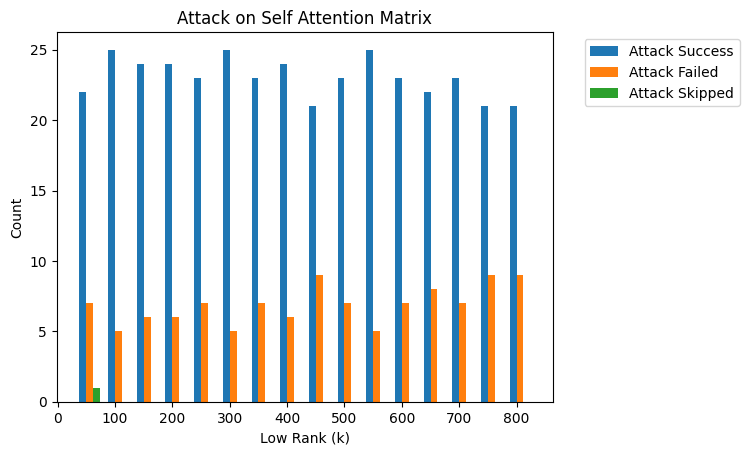

In [54]:
bar_width = 12
plt.bar(np.arange(50, 801, 50) - bar_width/2, success, width = bar_width, label="Attack Success")
plt.bar(np.arange(50, 801, 50) + bar_width/2, failed, width = bar_width, label="Attack Failed")
plt.bar(np.arange(50, 801, 50) + bar_width + bar_width/2, skipped, width = bar_width, label = "Attack Skipped")
plt.title("Attack on Self Attention Matrix")
plt.xlabel("Low Rank (k)")
plt.ylabel("Count")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()